In [8]:
import numpy as np
import random
import time
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [35]:
n_s=5    #Number of overlapping spheres that constitute a molecule shape

column_initials=['X_','Y_','Z_','D_']   #The first three letters represent the cartesian coordinates of a sphere and 'D_' represent the sphere diameter
column_names=[]   
for i in range(n_s):                    #Loop over the number of constituent spheres to save their coordinates and diameters
    for j in column_initials:
        column_names.append(j+str(i+1))

#Predicted_shapes dataframe contains the coordinates and diameters of each constituent sphere in a molecule
Predicted_shapes=pd.read_csv("C:/Users/esmak/Documents/PhD/LAMMPS/5-sphere/predicted_shapes_Adrian/Predictedshapes.csv",delimiter=",",names=column_names)
Predicted_shapes.head()

In [18]:
#To visualize molecule shapes 

def plot_sphere(shape,shape_id,n=5):
        
        fig=plt.figure(figsize=(5,5))
        ax=fig.add_subplot(111,projection='3d')
        u=np.linspace(0,2*np.pi,100)
        v=np.linspace(0,np.pi,100)
        color=['r','b','y','m','c']
        
        for i in range(n):
            x=shape[4*i]+shape[4*i+3]*np.outer(np.cos(u),np.sin(v))
            y=shape[4*i+1]+shape[4*i+3]*np.outer(np.sin(u),np.sin(v))
            z=shape[4*i+2]+shape[4*i+3]*np.outer(np.ones(np.size(u)),np.cos(v))
            ax.plot_surface(x,y,z,rstride=5,cstride=5,color=color[i])
        
        ax.set_xlabel('X axis')
        ax.set_ylabel('Y axis')
        ax.set_zlabel('Z axis')
        ax.set_xlim(-3, 3)
        ax.set_ylim(-3, 3)
        ax.set_zlim(-3, 3)
        ax.set_title('molecule'+str(shape_id+1))
        ax.set_aspect('equal')
        ax.view_init(0,45)
        

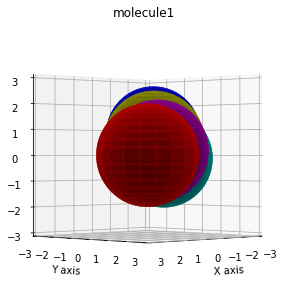

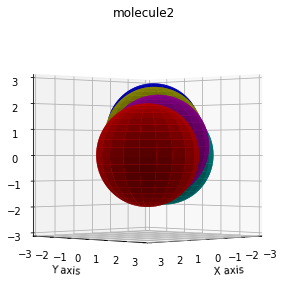

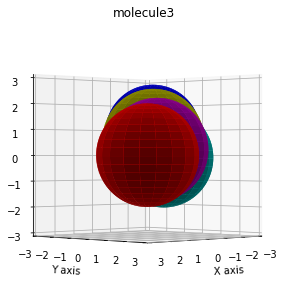

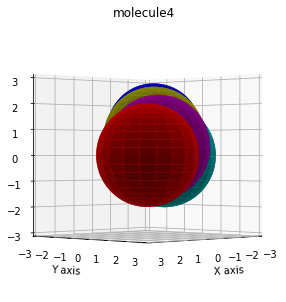

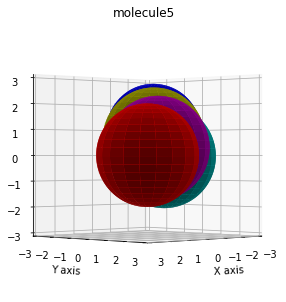

In [19]:
for i in range(n_s):
    shape=Predicted_shapes.iloc[i,:]
    plot_sphere(shape,i)

In [28]:
#Determine center of mass(com) and volume of a molecule composed of overlapping spheres with Monte Carlo method

def MonteCarlo_volume_com(shape,n_p,n_t):
    
    #n_p is the total number of random points generated and n_t is the number of simulations
    ns=len(shape)               #Number of constituent spheres of a molecule
    Volume_list=[]              #Saves the measured volumes for each simulation
    com=np.zeros((n_t,3))        #Saves the measured com for each simulation
    xlist, ylist, zlist=shape[:,0],shape[:,1],shape[:,2]     #Lists of coordinates of constituent spheres
    dmax=np.max(shape[:,3])       #The largest diameter within a molecule
    
    #The box dimensions should be large enough to make sure that the molecule will fit in the box
    xmin=np.min(xlist)-dmax/2
    xmax=np.max(xlist)+dmax/2
    ymin=np.min(ylist)-dmax/2
    ymax=np.max(ylist)+dmax/2
    zmin=np.min(zlist)-dmax/2
    zmax=np.max(zlist)+dmax/2
    box_volume=(xmax-xmin)*(ymax-ymin)*(zmax-zmin)
    
    for i in range(n_t):
        V=0             #V counts the number of random points within the molecule
        j=0
        xcom=0
        ycom=0
        zcom=0
        
        while j<=n_p:
            counter=0
            
            #Sample random x,y, and z coordinate values distributed uniformly between xmin and xmax
            xv=xmin+random.uniform(0,1)*(xmax-xmin)
            yv=ymin+random.uniform(0,1)*(ymax-ymin)
            zv=zmin+random.uniform(0,1)*(zmax-zmin)
            
            for k in range(ns):
                #Check whether the random point is within the sphere or not
                if np.sqrt((xv-shape[k,0])**2+(yv-shape[k,1])**2+(zv-shape[k,2])**2)<=shape[k,3]/2:
                    counter+=1
            
            #If the point is within at least one of the constituent spheres, then it is considered to be within the molecule as well
            #add 1 to V and its coordinates to the coordinates of com
            if counter>0:
                V+=1
                xcom+=xv
                ycom+=yv
                zcom+=zv
            j+=1
                
        volume=box_volume*V/n_p              #Calculate the molecule volume
        com[i]=[xcom/V, ycom/V, zcom/V]      #Calculate the com of the molecule
        Volume_list.append(volume)
        
    mean_volume=np.mean(Volume_list)
    error=np.std(Volume_list,ddof=1)
    mean_com=com.mean(axis=0)
    return mean_volume,error,list(mean_com)

In [39]:
def MonteCarlo_inertia(shape,n_p,n_t,m,com):
    
    #m is the mass and com is determined with MonteCarlo_volume_com
    ns=len(shape)
    xlist, ylist, zlist=shape[:,0],shape[:,1],shape[:,2]
    dmax=np.max(shape[:,3])
    xmin=np.min(xlist)-dmax/2
    xmax=np.max(xlist)+dmax/2
    ymin=np.min(ylist)-dmax/2
    ymax=np.max(ylist)+dmax/2
    zmin=np.min(zlist)-dmax/2
    zmax=np.max(zlist)+dmax/2
    
    I=np.zeros((n_t,6))        #The 6 moment of inertia
    for i in range(n_t):
        I_xx=0
        I_yy=0
        I_zz=0
        I_xy=0
        I_xz=0
        I_yz=0
        V=0                    #V counts the number of random points within the molecule
        j=0    
            
        while j<=n_p:
            
            counter=0
            #Sample random x,y, and z coordinate values distributed uniformly between xmin and xmax
            xv=xmin+random.uniform(0,1)*(xmax-xmin)
            yv=ymin+random.uniform(0,1)*(ymax-ymin)
            zv=zmin+random.uniform(0,1)*(zmax-zmin)
            
            for k in range(ns):
                #Check whether the random point is within the sphere or not
                if np.sqrt((xv-shape[k,0])**2+(yv-shape[k,1])**2+(zv-shape[k,2])**2)<=shape[k,3]/2:
                        counter+=1
            
            #If the point is within at least one of the constituent spheres, then it is considered to be within the molecule as well
            #add 1 to V and it contributes to the moment of inertia
            if counter>0:
                
                V+=1
                I_xx+=((com[1]-yv)**2+(com[2]-zv)**2)
                I_yy+=((com[0]-xv)**2+(com[2]-zv)**2)
                I_zz+=((com[0]-xv)**2+(com[1]-yv)**2)
                I_xy=I_xy-(com[0]-xv)*(com[1]-yv)
                I_xz=I_xz-(com[0]-xv)*(com[2]-zv)
                I_yz=I_yz-(com[1]-yv)*(com[2]-zv)
            j+=1

        I[i]=[I_xx,I_yy,I_zz,I_xy,I_xz,I_yz]
        I[i]=[key*m/V for key in I[i]]
            
    mean_I=I.mean(axis=0)
    return list(mean_I)

In [36]:
n_m=len(Predicted_shapes)    #Number of predicted molecules
n_c=len(column_initials)     #Number of variables that define a sphere

list_of_names=['molecule'+str(key+1) for key in range(n_m)]

array_of_test_shapes=[np.array(Predicted_shapes.iloc[key,:]).reshape((n_s,n_c)) for key in range(n_m)]

molecules_info={'molecule_name':list_of_names, 'shape_array':array_of_test_shapes}

df=pd.DataFrame(data=molecules_info)
df=df.set_index('molecule_name')

In [37]:
df.head()

,shape_array
molecule_name,
molecule1,"[[0.0, 0.0, 0.0, 1.99999999999999], [-0.358270..."
molecule2,"[[0.0, 0.0, 0.0, 1.99999999999999], [-0.308416..."
molecule3,"[[0.0, 0.0, 0.0, 1.99999999999999], [-0.304873..."
molecule4,"[[0.0, 0.0, 0.0, 1.99999999999999], [-0.296241..."
molecule5,"[[0.0, 0.0, 0.0, 1.99999999999999], [-0.281562..."


In [47]:
molecule_volume=[]
volume_error=[]
molecule_com=[]

start_time=time.time()
for shape in df['shape_array']:
    
    volume, error, com=MonteCarlo_volume_com(shape,10000000,5)
    molecule_volume.append(volume)
    volume_error.append(error)
    molecule_com.append(com)
    
print('Time for calculation of molecule volume and center of mass: {} sec'.format(time.time()-start_time))

df['molecule_volume']=molecule_volume
df['volume_error']=volume_error
df['molecule_com']=molecule_com

Time for calculation of molecule volume and center of mass: 2781.2769153118134 sec


In [49]:
molecule_inertia=[]

start_time=time.time()
for index,row in df.iterrows():
    
    moment_of_inertia=MonteCarlo_inertia(df.loc[index,'shape_array'],10000000,5,1,df.loc[index,'molecule_com'])
    molecule_inertia.append(moment_of_inertia)

print('Time for calculation of moment of inertia: {} sec'.format(time.time()-start_time))
df['molecule_inertia']=molecule_inertia

Time for calculation of moment of inertia: 2976.2523968219757 sec


In [50]:
df.head()

,shape_array,molecule_volume,volume_error,molecule_com,molecule_inertia
molecule_name,,,,,
molecule1,"[[0.0, 0.0, 0.0, 1.99999999999999], [-0.358270...",7.958296,0.002730,"[-0.33280515672299266, 0.052698974421693565, 0...","[0.647916438722703, 0.7444791946504352, 0.5600..."
molecule2,"[[0.0, 0.0, 0.0, 1.99999999999999], [-0.308416...",8.045061,0.002648,"[-0.28446506124328996, 0.11483928858753052, 0....","[0.6843001959412074, 0.7451572334119383, 0.548..."
molecule3,"[[0.0, 0.0, 0.0, 1.99999999999999], [-0.304873...",8.067091,0.001454,"[-0.2960484329054688, 0.08851806258409352, 0.2...","[0.679086493204741, 0.7470014094154266, 0.5521..."
molecule4,"[[0.0, 0.0, 0.0, 1.99999999999999], [-0.296241...",8.341211,0.004389,"[-0.28796232822764584, 0.1462709517919619, 0.2...","[0.7050577092846574, 0.7494899893926448, 0.565..."
molecule5,"[[0.0, 0.0, 0.0, 1.99999999999999], [-0.281562...",8.309803,0.003139,"[-0.2797167913705222, 0.1499656959355259, 0.27...","[0.705018194257954, 0.7436140746943575, 0.5643..."


In [64]:
df.to_csv("C:/Users/esmak/Documents/PhD/LAMMPS/5-sphere/predicted_shapes_Adrian/Moleculeinfo.csv")